This notebook looks for the top words within each of the obtained clusters.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [7]:
# Read file with the predictions
data_predictions = pd.read_parquet("data_and_predictions", columns=["id", "prediction"])
# Read file with the texts
data_texts = pd.read_csv('../cleaned_mfd2_liwc_results.csv', usecols = ['id', 'cleaned_text'])

# Merge two dataframes 
merged_df = pd.merge(data_predictions, data_texts, on='id', how='inner')

# Create new dataframes for each cluster
cluster_0 = merged_df[merged_df.prediction == 0]
cluster_1 = merged_df[merged_df.prediction == 1]

In [10]:
cluster_0

,id,prediction,cleaned_text
0,97m4m,0,do you have a strong voice or a well built fr...
1,q412v,0,nothing but opportunity exists if you are fe...
3,rvjcf,0,context last semester i was taking 11 credit...
4,se83q,0,the title pretty much says it all this whole ...
5,sigw5,0,i find that writing out what i want to do and ...
...,...,...,...
836671,kfre9u2,0,me too but im going to bed early to wake up e...
836672,kfrjli5,0,i was in the same shoes as you try to think s...
836673,kfrn46u,0,why 5 programming languages i d try to master...
836674,kfrn5yj,0,i did this and now its like three years later ...


In [11]:
cluster_1

,id,prediction,cleaned_text
2,rd166,1,i ve been working at a horrible place for thre...
17,xotkf,1,i m 19 f i am going to start going to counsel...
19,105w28,1,i m a stay at home father of four i work occa...
20,10tjyx,1,a short guide on how to change your internal i...
30,143c6i,1,while arguing debating i get all worked up an...
...,...,...,...
836646,kfql8i8,1,i m not scared of being intimate with someone ...
836649,kfqonuz,1,the news wants you to be scared it s how th...
836657,kfqy6e6,1,everyone here is giving you amazing advice i...
836658,kfqzzbo,1,nobody ever invites me anywhere else in gener...


Create functions for counting words in each cluster

In [34]:
def tokenize_words(text):
    '''
    Tokenizes text into list of words, excluding stop words 

    Inputs:
      - text (str): text

    Outputs:
      (list): list of filtered words, without stop words
    '''
    stop_words = [
    # Standard English stop words
    "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "are not", "as", "at", 
    "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can not", "cannot", "could", 
    "could not", "did", "did not", "do", "does", "does not", "doing", "do not", "down", "during", "each", "few", "for", 
    "from", "further", "had", "had not", "has", "has not", "have", "have not", "having", "he", "he s", "he would", 
    "he will", "he s", "her", "here", "here s", "hers", "herself", "him", "himself", "his", "how", "how s", "i", 
    "i would", "i will", "i m", "i have", "if", "in", "into", "is", "is not", "it", "it s", "its", "itself", "let us", 
    "me", "more", "most", "must not", "my", "myself", "no", "nor", "not", "of", "off", "on", "once", "only", "or", 
    "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "shall not", "she", "she s", 
    "she would", "she will", "she s", "should", "should not", "so", "some", "such", "than", "that", "that s", "the", 
    "their", "theirs", "them", "themselves", "then", "there", "there s", "these", "they", "they would", "they will", 
    "they are", "they have", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "was not", 
    "we", "we would", "we will", "we are", "we have", "were", "were not", "what", "what s", "when", "when s", 
    "where", "where s", "which", "while", "who", "who s", "whom", "why", "why s", "with", "will not", "would", 
    "would not", "you", "you would", "you will", "you are", "you have", "your", "yours", "yourself", "yourselves",
    "can", "re", "don", "ve", "isn", "didn", "doesn", "without", "might", "ll", "day", "become", "always", "now",
    "day", "may", "etc", "though", "made", "also", "lot", "many", "much",
    
    # Topic specific words
    "will", "feel", "want", "time", "want", "life", "good",
    
    # Reddit-specific stop words
    "r", "u", "reddit", "subreddit", "post", "posted", "comment", "thread", "upvote", "downvote", "karma", "flair", 
    "mods", "moderator", "nsfw", "ama", "op", "tldr", "edit", "title", "link", "url", "http", "https", "www", 
    "com", "org", "net", "jpg", "png", "gif", "imgur", "youtube", "youtu", "sub", "user", "self", "removed", 
    "deleted", "please", "thanks", "thank", "hi", "hello", "help", "lol", "btw", "imo", "imho", "fyi", "anyone", 
    "everyone", 
    
    # Common fillers and additional terms
    "just", "like", "know", "get", "got", "make", "go", "going", "think", "see", "say", "said", "would", "one", 
    "two", "three", "really", "actually", "thing", "things", "people", "even", "way", "something", "anything", 
    "everything", "maybe", "someone", "anywhere", "everyone", "everybody", "someone", "anyone", "thing", "things"]
    
    words_list = []

    words = text.split()

    for word in words:
        if len(word) < 2:
            continue

        if word in stop_words:
            continue

        words_list.append(word)

    return words_list


def count_words(data):
    '''
    Create a dictionary that maps words with their frequency 

    Inputs:
      - data (series): post's texts

    Outputs:
      - (dict): dictionary mapping words with their frequencies

    '''

    words_counts = {}

    for entry in data:
        row_words = tokenize_words(entry)

        for word in row_words:
            words_counts[word] =  words_counts.get(word, 0) + 1

    sorted_dict= dict(sorted(words_counts.items(), key=lambda item: item[1],
                                                                  reverse=True))
    return sorted_dict

In [35]:
#Apply function to each cluster
dict_cluster0 = count_words(cluster_0["cleaned_text"])
dict_cluster1 = count_words(cluster_1["cleaned_text"])

Plot wordclouds for each cluster

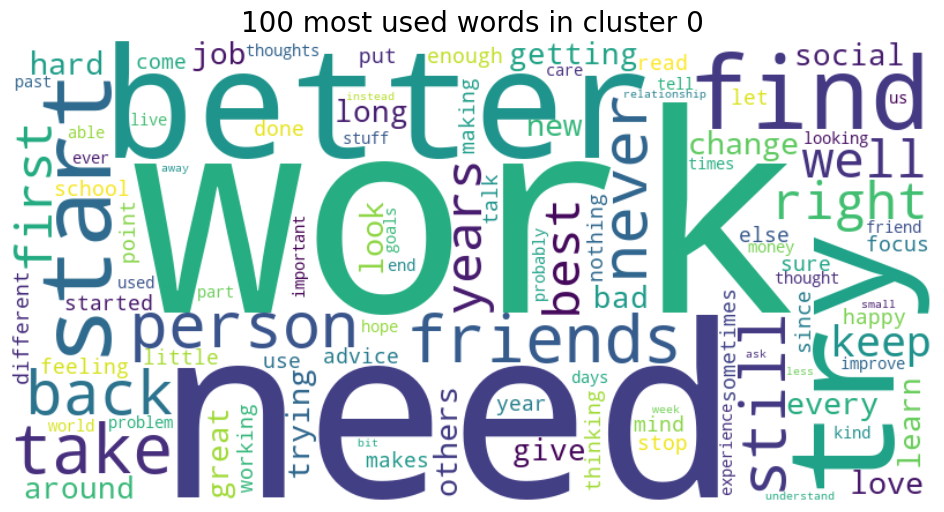

In [36]:
wordcloud = WordCloud(width=800, height=400, background_color='white',
                                                  colormap='viridis',
                      max_words=100, contour_color='steelblue', contour_width=2)

wordcloud.generate_from_frequencies(dict_cluster0)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('100 most used words in cluster 0', fontsize=20)
plt.axis('off')
plt.show()

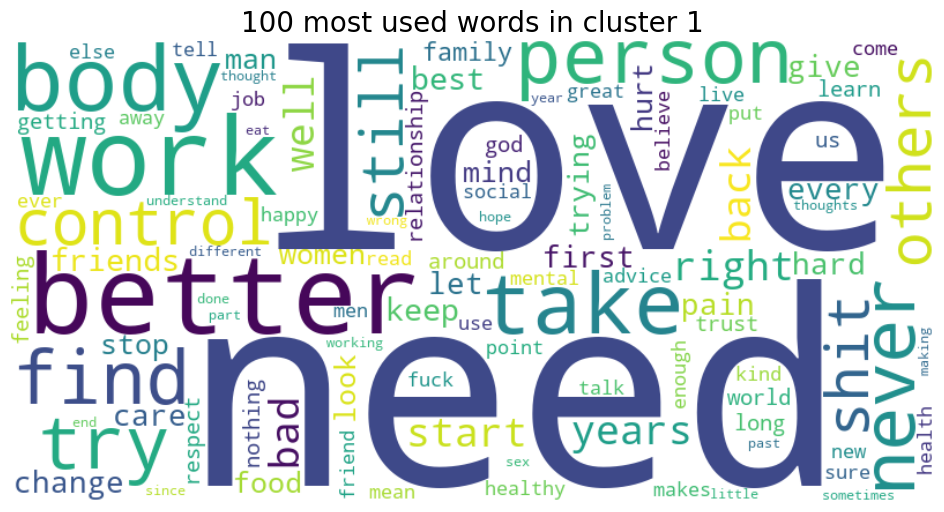

In [40]:
wordcloud = WordCloud(width=800, height=400, background_color='white',
                                                  colormap='viridis',
                      max_words=100, contour_color='steelblue', contour_width=2)

wordcloud.generate_from_frequencies(dict_cluster1)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('100 most used words in cluster 1', fontsize=20)
plt.axis('off')
plt.show()